In [1]:
import pandas as pd
import pandas_profiling
import matplotlib.pyplot as plt


In [2]:
train = pd.read_csv('data/challenge3_train.csv')
test = pd.read_csv('data/challenge3_test.csv')
data = pd.concat([train, test])
print(f'train: {train.shape} | test: {test.shape}, all: {data.shape}')
train.head(2)

train: (50000, 33) | test: (50000, 32), all: (100000, 33)


,id,target,f0,f1,f2,f3,f4,f5,f6,f7,...,f21,f22,f23,f24,f25,f26,f27,f28,f29,f30
0,0,1,0.0,5.0,0.0,4.0,3598.0,M,3.0,-7.2430,...,3.0,14.2364,0.0,NaN,4.0,1.0,5.0,PS,2.0,0.834041
1,1,0,NaN,5.0,4.0,NaN,2072.0,NaN,4.0,-1.6662,...,3.0,NaN,2.0,3.0,NaN,1.0,5.0,DT,5.0,0.686021


In [3]:
data = data.drop(['id', 'target'], axis=1)

In [5]:
# Generate reports
#pandas_profiling.ProfileReport(train, minimal=False).to_file('train_report.html')
#pandas_profiling.ProfileReport(test, minimal=False).to_file('test_report.html')

Comparing train and test data: 
From reports we see f13 has different data distribution; more outliers around 28 and 60.


High corelevance with f10 and f14

Categories:
f5: M, F
f15: A, B, C

In [218]:
print('Percentage of values being NaN')
nans = data.isna().sum().map(lambda x: x / len(data) * 100).round(1)
pd.DataFrame({'Nan percentage': nans})

Percentage of values being NaN


,Nan percentage
f0,66.1
f1,14.1
f2,14.3
f3,13.3
f4,17.7
f5,12.3
f6,13.5
f7,17.9
f8,0.3
f9,13.5


In [219]:
nunique_vals = list()

for column in data:
    nunique_vals.append(data[column].nunique())
print('Unique values in columns:')
pd.DataFrame({'columns': data.columns,
              'unique_values': nunique_vals})

Unique values in columns:


,columns,unique_values
0,f0,2
1,f1,6
2,f2,6
3,f3,6
4,f4,3767
5,f5,2
6,f6,6
7,f7,67091
8,f8,8175
9,f9,6


In [220]:
for column in data.columns:
    unique = data[column].unique()
    count = len(unique)
    print('Column', column)
    print('Values:', unique)
    print('Number of unique:', count)
    print('\n')
    

Column f0
Values: [ 0. nan  1.]
Number of unique: 3


Column f1
Values: [ 5.  1. nan  2.  3.  4.  0.]
Number of unique: 7


Column f2
Values: [ 0.  4.  2. nan  3.  5.  1.]
Number of unique: 7


Column f3
Values: [ 4. nan  2.  1.  3.  5.  0.]
Number of unique: 7


Column f4
Values: [3598. 2072.  862. ... 1261. 1257.  518.]
Number of unique: 3768


Column f5
Values: ['M' nan 'F']
Number of unique: 3


Column f6
Values: [ 3.  4.  5. nan  1.  0.  2.]
Number of unique: 7


Column f7
Values: [ -7.243   -1.6662  -0.12   ...  -6.8409  -5.4951 -10.1088]
Number of unique: 67092


Column f8
Values: [13.9681 14.0242 14.2174 ... 13.803  14.6088 13.8286]
Number of unique: 8176


Column f9
Values: [ 3.  0.  1.  5. nan  2.  4.]
Number of unique: 7


Column f10
Values: [0.000e+00 3.200e+01 5.000e+00 8.400e+01 1.200e+01 1.700e+01 1.900e+01
 5.240e+02 1.100e+01 2.200e+01 3.800e+01 4.500e+01 3.000e+00 2.000e+00
 6.000e+00 4.000e+00 2.900e+01 9.100e+01 5.000e+01 7.000e+00 7.200e+01
 5.100e+01 1.600e+01 3.5

Column f0
0.0    27.609
1.0     6.308
NaN    66.083
Name: f0, dtype: float64


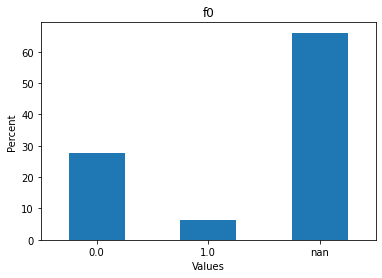

Column f1
0.0     0.094
1.0    10.620
2.0    18.155
3.0    18.446
4.0    20.137
5.0    18.416
NaN    14.132
Name: f1, dtype: float64


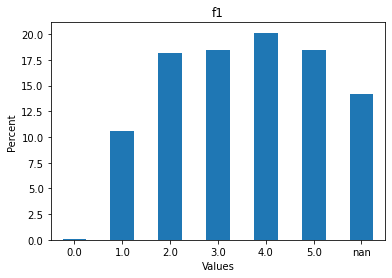

Column f2
0.0    39.582
1.0     1.763
2.0    17.627
3.0     7.431
4.0    13.219
5.0     6.122
NaN    14.256
Name: f2, dtype: float64


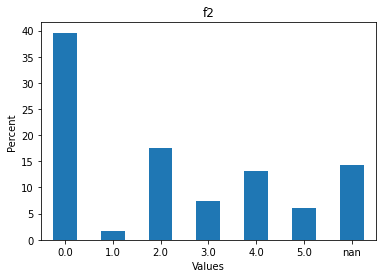

Column f3
0.0     0.001
1.0    10.749
2.0    10.775
3.0    23.699
4.0    24.288
5.0    17.201
NaN    13.287
Name: f3, dtype: float64


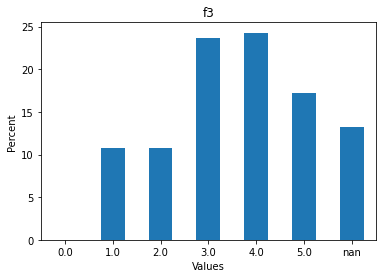

Column f5
F      44.454
M      43.267
NaN    12.279
Name: f5, dtype: float64


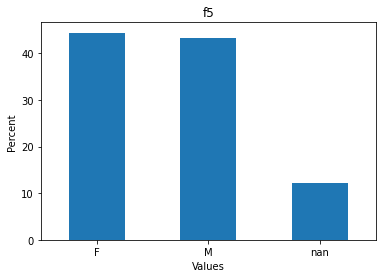

Column f6
0.0     4.426
1.0    12.929
2.0    14.262
3.0    14.909
4.0    21.273
5.0    18.655
NaN    13.546
Name: f6, dtype: float64


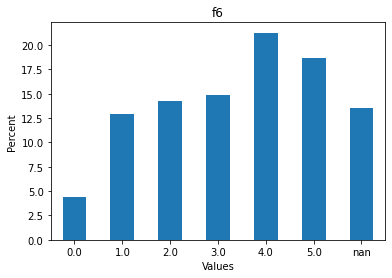

Column f9
0.0    65.682
1.0     1.893
2.0     2.052
3.0     4.757
4.0     3.431
5.0     8.664
NaN    13.521
Name: f9, dtype: float64


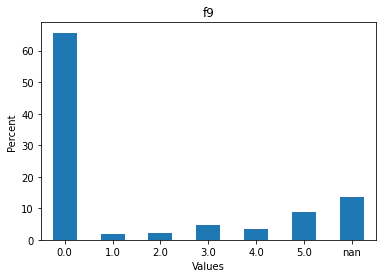

Column f11
-1.0      0.012
 0.0      0.750
 1.0      0.169
 2.0      0.283
 3.0      0.849
 4.0      3.380
 5.0      2.326
 6.0      8.138
 7.0     23.063
 8.0      1.968
 9.0      2.706
 10.0     6.443
 11.0    26.772
 NaN     23.141
Name: f11, dtype: float64


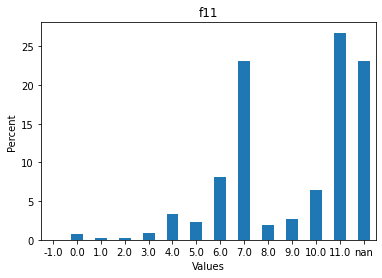

Column f15
A      31.022
B      16.547
C      33.286
NaN    19.145
Name: f15, dtype: float64


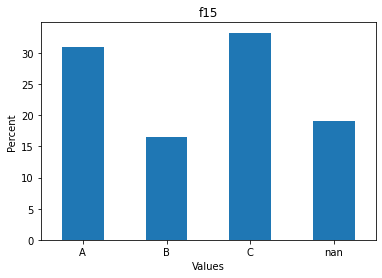

Column f17
0.0     8.542
1.0    20.458
2.0     0.002
3.0    28.618
4.0     5.294
5.0    15.389
NaN    21.697
Name: f17, dtype: float64


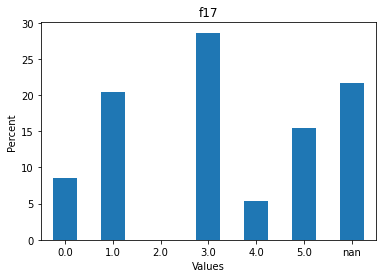

Column f18
0.0     0.001
1.0     5.567
2.0     8.983
3.0    15.903
4.0    29.700
5.0    21.187
NaN    18.659
Name: f18, dtype: float64


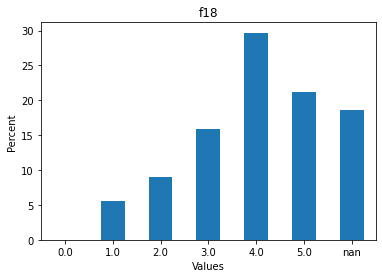

Column f19
0.0    16.731
1.0    11.928
2.0     0.001
3.0    20.927
4.0    15.117
5.0    24.540
NaN    10.756
Name: f19, dtype: float64


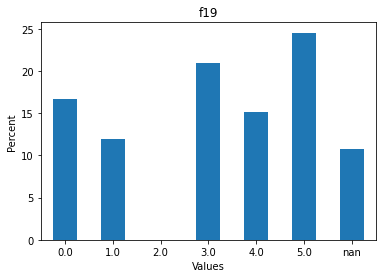

Column f20
A      6.138
B      4.071
C      5.322
D      2.872
E      3.632
F      2.757
G      0.573
H      5.150
I      3.316
J      0.333
K      3.580
L      0.290
M      5.359
N      6.701
O      4.227
P      6.385
Q      5.040
R      5.614
S      0.756
T      5.089
U      5.483
V      0.525
W      1.405
X      5.326
Y      6.061
Z      0.982
NaN    3.013
Name: f20, dtype: float64


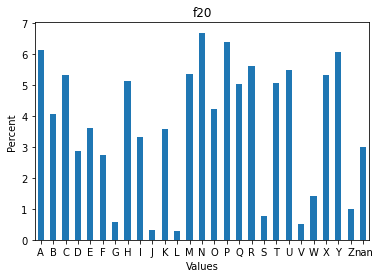

Column f21
0.0     0.001
1.0    14.397
2.0    15.950
3.0    23.668
4.0    20.038
5.0    11.414
NaN    14.532
Name: f21, dtype: float64


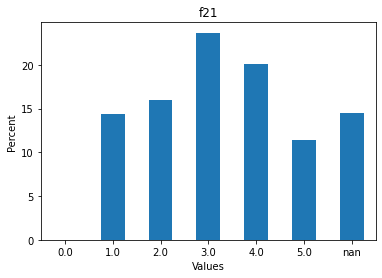

Column f23
0.0     7.223
1.0    14.338
2.0    21.068
3.0    20.012
4.0    11.736
5.0    10.158
NaN    15.465
Name: f23, dtype: float64


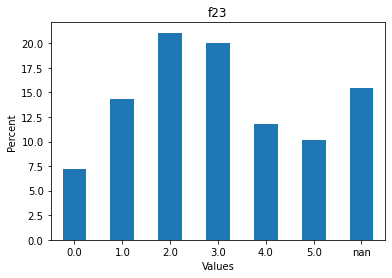

Column f24
0.0     0.385
1.0    13.419
2.0    11.688
3.0    25.975
4.0    16.495
5.0    11.587
NaN    20.451
Name: f24, dtype: float64


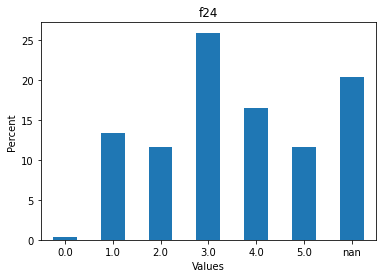

Column f25
0.0     5.171
1.0    21.024
2.0    17.456
3.0    17.236
4.0    14.236
5.0     8.334
NaN    16.543
Name: f25, dtype: float64


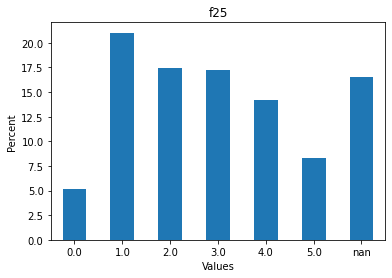

Column f26
0.0    14.760
1.0    66.343
NaN    18.897
Name: f26, dtype: float64


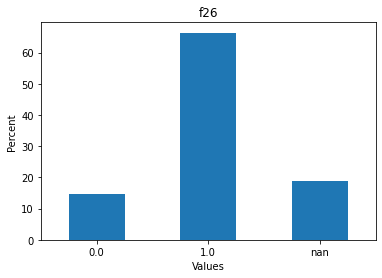

Column f27
0.0     8.240
1.0     5.855
2.0    13.121
3.0     2.185
4.0     7.105
5.0    47.821
NaN    15.673
Name: f27, dtype: float64


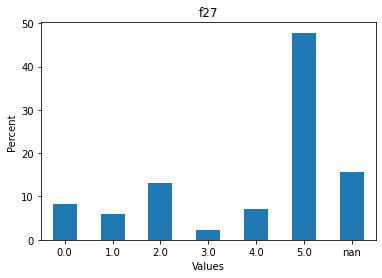

Column f29
0.0     0.570
1.0     5.564
2.0    14.284
3.0     5.726
4.0     1.435
5.0    57.649
NaN    14.772
Name: f29, dtype: float64


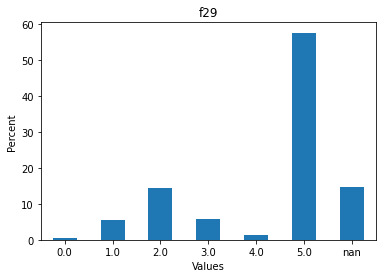

In [217]:
print('Distribution of unique values and Nan:')      
for column in data.columns:
    count = len(data[column].unique())
    if count > 30:
        continue # Too many values to compute/display graph on
    value_percent = data[column].value_counts(dropna=False, sort=False).map(lambda x: x / len(data[column]) * 100).sort_index()
    print('Column', column)
    print(value_percent)
    
    ax = value_percent.plot.bar(rot=0)
    ax.set_title(column)
    plt.ylabel('Percent')
    plt.xlabel('Values')
    plt.show()


## From the graphs we see the following
Graphs with zero (0) as noise, meaning we can probably drop them:
f1, f3, f18, f21, f24, f29

f11 have noise in -1, in addition to 0.

f17, f19 have only 0.002% and 0.001% 2 value counts

In [23]:
train.head(1)

,id,target,f0,f1,f2,f3,f4,f5,f6,f7,...,f21,f22,f23,f24,f25,f26,f27,f28,f29,f30
0,0,1,0.0,5.0,0.0,4.0,3598.0,M,3.0,-7.243,...,3.0,14.2364,0.0,NaN,4.0,1.0,5.0,PS,2.0,0.834041


In [67]:
zero_columns = ['f1', 'f3', 'f11', 'f18', 'f21', 'f24', 'f29']

In [68]:
print('Look into zero values in train and test set')
for column in zero_columns:
    print('\n', column)
    print('Zero value in feature grouped by target:')
    print(train.loc[train[column] == 0].groupby([column, 'target']).size())
    print('\n')
    print('Zero value count in train vs test set')
    print('train:', train.loc[train[column] == 0].shape[0])
    print('test :', test.loc[test[column] == 0].shape[0])
    
    if (column == 'f11'):
        print('\n')
        print(train.loc[train[column] == -1].groupby([column, 'target']).size())
        print('train:', train.loc[train['f11'] == -1].shape[0])
        print('test :', test.loc[test['f11'] == -1].shape[0])

print('We see 0 value can be removed/changed safely from f3, f18, f21')

Look into zero values in train and test set

 f1
Zero value in feature grouped by target:
f1   target
0.0  0         30
     1         16
dtype: int64


Zero value count in train vs test set
train: 46
test : 48

 f3
Zero value in feature grouped by target:
f3   target
0.0  0         1
dtype: int64


Zero value count in train vs test set
train: 1
test : 0

 f11
Zero value in feature grouped by target:
f11  target
0.0  0         217
     1         154
dtype: int64


Zero value count in train vs test set
train: 371
test : 379


f11   target
-1.0  0         4
      1         2
dtype: int64
train: 6
test : 6

 f18
Zero value in feature grouped by target:
Series([], dtype: int64)


Zero value count in train vs test set
train: 0
test : 1

 f21
Zero value in feature grouped by target:
Series([], dtype: int64)


Zero value count in train vs test set
train: 0
test : 1

 f24
Zero value in feature grouped by target:
f24  target
0.0  0         119
     1          78
dtype: int64


Zero value count 

f1   target
0.0  0         30
     1         16
dtype: int64

(5306, 32)

# Now explore train data (with known target)

Tageet distribution:


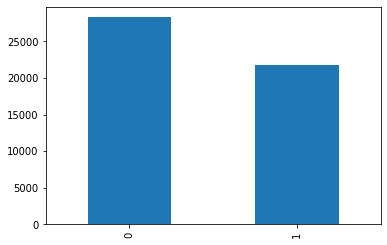

# We see targets are not balanced


In [152]:
print('Tageet distribution:')
train['target'].value_counts().plot.bar()
plt.show()
print('We see targets are not balanced')

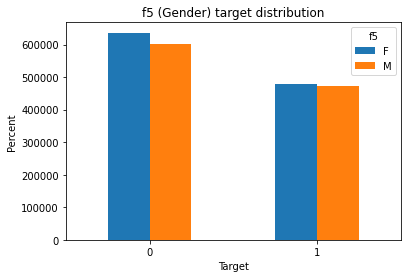

We see that F and M have very similar target distribution


In [154]:
group = train.groupby(['f5', 'target'])
percent = group.size().groupby(level=0).apply(lambda count: count / len(count) * 100).rename('Percent').reset_index()
pivot = percent.pivot('target', 'f5', 'Percent')

ax = pivot.plot.bar(stacked=False, rot=0)
plt.title('f5 (Gender) target distribution')
plt.ylabel('Percent')
plt.xlabel('Target')
plt.show()
print('We see that F and M have very similar target distribution')

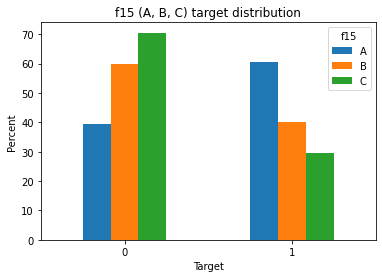

We see that A, B, C have very different target distribution


In [87]:
group = train.groupby(['f15', 'target'])
percent = group.size().groupby(level=0).apply(lambda count: 100 * count / count.sum()).rename('Percent').reset_index()
pivot = percent.pivot('target', 'f15', 'Percent')

ax = pivot.plot.bar(stacked=False, rot=0)
plt.title('f15 (A, B, C) target distribution')
plt.ylabel('Percent')
plt.xlabel('Target')
plt.show()
print('We see that A, B, C have very different target distribution')

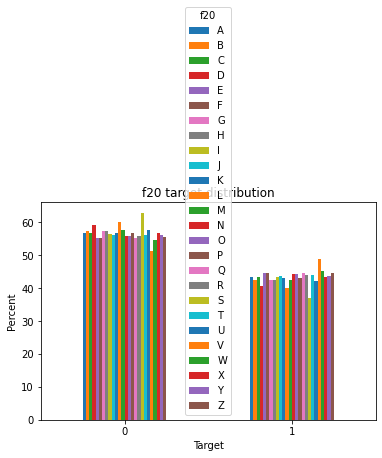

We see that the labels have very simmilar target distribution


In [94]:
group = train.groupby(['f20', 'target'])
percent = group.size().groupby(level=0).apply(lambda count: 100 * count / count.sum()).rename('Percent').reset_index()
pivot = percent.pivot('target', 'f20', 'Percent')

ax = pivot.plot.bar(stacked=False, rot=0)
plt.title('f20 target distribution')
plt.ylabel('Percent')
plt.xlabel('Target')
plt.show()
print('We see that the labels have very simmilar target distribution')

There are some differences in training and test data


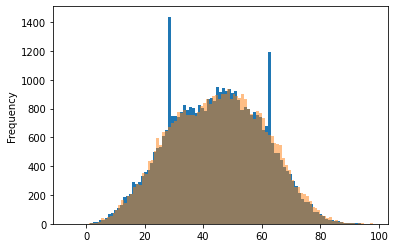

Here we see the frequency of some values in the training data are higher than in test


,frequency count
"(27.99, 29.02]",1437
"(61.98, 63.01]",1195


In [268]:
print('There are some differences in training and test data')
train['f13'].plot.hist(bins=100)
test['f13'].plot.hist(bins=100, alpha=.5)

plt.show()
print('Here we see the frequency of some values in the training data are higher than in test')
pd.DataFrame({'frequency count': train['f13'].value_counts(bins=100).head(60).head(2)})

In [4]:
# Out of curiosity we want to explore the rows with a 1 and a 0 separately
true_train_data = train.loc[train['target'] == 1]
false_train_data = train.loc[train['target'] == 0]


,id,target,f0,f1,f2,f3,f4,f5,f6,f7,...,f21,f22,f23,f24,f25,f26,f27,f28,f29,f30
1,1,0,NaN,5.0,4.0,NaN,2072.0,NaN,4.0,-1.6662,...,3.0,NaN,2.0,3.0,NaN,1.0,5.0,DT,5.0,0.686021
2,2,0,1.0,1.0,4.0,2.0,862.0,M,3.0,-0.1200,...,NaN,NaN,2.0,2.0,3.0,1.0,2.0,vq,5.0,1.141271
3,3,0,NaN,NaN,2.0,1.0,409.0,F,5.0,-16.2169,...,5.0,NaN,2.0,1.0,5.0,1.0,0.0,Bx,5.0,0.662382
5,5,0,NaN,2.0,2.0,2.0,190.0,F,NaN,-12.5919,...,2.0,NaN,NaN,4.0,3.0,1.0,0.0,mX,3.0,0.749583
10,10,0,NaN,2.0,2.0,2.0,406.0,F,4.0,-1.7851,...,NaN,13.9805,2.0,NaN,4.0,NaN,2.0,gj,5.0,1.022864


In [9]:
true_profile = pandas_profiling.ProfileReport(true_train_data, minimal=True).to_file('true_train_report.html')
true_profile = pandas_profiling.ProfileReport(false_train_data, minimal=True).to_file('false_train_report.html')

In [ ]:
# By looking at the different in distribution of values within each column with respect to whether the target is a 0 or a 1
# the interesting columns seem to be:
# f0, f1, f2, f3, f4, f6, f13, f14(?) f15, f17, f18, f19, f21, f23, f24, f25, f26